<a href="https://colab.research.google.com/github/hila-chefer/Transformer-Explainability/blob/main/Transformer_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transformer Interpretability Beyond Attention Visualization**

In [34]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

In [35]:
# CIFAR-10 class indices to names
# %%capture

CLS2IDX = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

print(CLS2IDX)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [36]:
print(torch.cuda.is_available())

True


# Model Select

In [53]:
from baselines.ViT.ViT_LRP_default import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_LRP_entmax import vit_base_patch16_224 as vit_LRP_entmax
from baselines.ViT.ViT_LRP_AdaptiveEntmax import vit_base_patch16_224 as vit_LRP_AdaptiveEntmax

from modules.layers_ours import Linear

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# initialize ViT pretrained
models = {
    1: "vit_LRP",
    2: "vit_LRP_entmax",
    3: "vit_LRP_AdaptiveEntmax"
}
model_name = models[3]

if model_name == "vit_LRP": model = vit_LRP(pretrained=False)
elif model_name == "vit_LRP_entmax": model = vit_LRP_entmax(pretrained=False)
elif model_name == "vit_LRP_AdaptiveEntmax": model = vit_LRP_AdaptiveEntmax(pretrained=True)

# CIFAR(10 classes)에 맞게 최종 분류 헤드를 교체
model.head = Linear(model.head.in_features, 10)
print("model head:", model.head.out_features)
model = model.cuda()

model head: 10


# Data Load

In [54]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

root = "./dataset/cifar10"

full_trainset = datasets.CIFAR10(root=root, train=True, download=True, transform=transform)
testset       = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)

# CIFAR-10 클래스 이름 → idx 매핑
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(full_trainset.classes)}
print("class_to_idx:", class_to_idx)

# Train / Valid split (90% / 10%)
train_size = int(len(full_trainset) * 0.9)   # 45,000
valid_size = len(full_trainset) - train_size  # 5,000

trainset, validset = random_split(full_trainset, [train_size, valid_size])

# 빠른 실험 결과 확인을 위해 set 크기 줄이기
# trainset = Subset(trainset, list(range(9000)))
# validset = Subset(validset, list(range(1000)))
# testset = Subset(testset, list(range(1000)))

# DataLoaders
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)
valloader   = DataLoader(validset, batch_size=16, shuffle=False)
testloader  = DataLoader(testset,  batch_size=16, shuffle=False)

print("Train:", len(trainset))
print("Val:",   len(validset))
print("Test:",  len(testset))

class_to_idx: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Train: 45000
Val: 5000
Test: 10000


# Training

In [39]:
import torch.optim as optim
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [40]:
from tqdm import tqdm

num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # ----- Training -----
    model.train()
    # Hook: 중간 레이어 출력/입력을 실시간으로 가로채는 함수
    model.enable_hooks = False
    total_train_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for images, labels in progress_bar:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

    avg_train_loss = total_train_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # ----- Validation -----
    model.eval()
    model.enable_hooks = False
    total_val_loss = 0.0
    correct = 0
    total = 0
    val_bar = tqdm(valloader, desc=f"[Val]   Epoch {epoch+1}/{num_epochs}", leave=False)
    
    # with torch.set_grad_enabled(True):
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            val_bar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

    avg_val_loss = total_val_loss / len(valloader)
    val_acc = 100 * correct / total
    val_losses.append(avg_val_loss)


    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}%")

Epoch 2/5:   0%|          | 0/2813 [00:00<?, ?it/s]                                    

Epoch [1/5] | Train Loss: 0.3546 | Val Loss: 0.1996 | Val Acc: 93.46%


Epoch 3/5:   0%|          | 0/2813 [00:00<?, ?it/s]                                    

Epoch [2/5] | Train Loss: 0.1420 | Val Loss: 0.1683 | Val Acc: 94.24%


Epoch 4/5:   0%|          | 0/2813 [00:00<?, ?it/s]                                    

Epoch [3/5] | Train Loss: 0.1117 | Val Loss: 0.1920 | Val Acc: 93.64%


Epoch 5/5:   0%|          | 0/2813 [00:00<?, ?it/s]                                    

Epoch [4/5] | Train Loss: 0.0889 | Val Loss: 0.1648 | Val Acc: 94.74%


Epoch [5/5] | Train Loss: 0.0770 | Val Loss: 0.1545 | Val Acc: 94.88%


In [41]:
model_weight = f"{model_name}_cifar10_epoch{epoch+1}"

In [42]:
import json
import os
from datetime import datetime

# --- 저장 폴더 생성 ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"record/evaluations/{model_weight}/{timestamp}"
os.makedirs(save_dir, exist_ok=True)

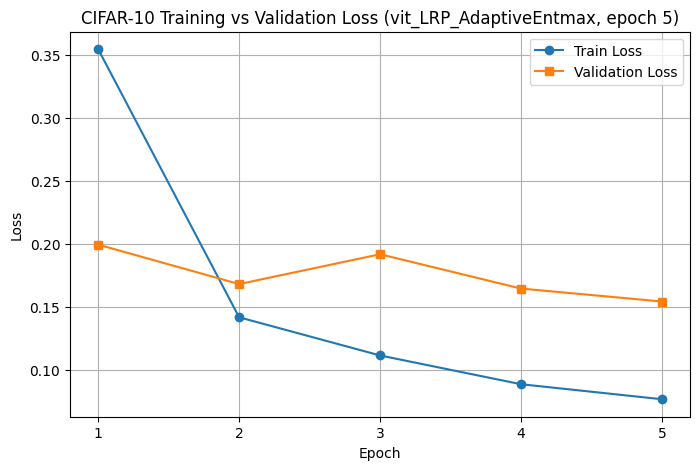

Saved figure at: record/evaluations/vit_LRP_AdaptiveEntmax_cifar10_epoch5/20251120_013303/loss\CIFAR-10 Training vs Validation Loss (vit_LRP_AdaptiveEntmax, epoch 5).svg


In [43]:
'''
loss 기록 및 loss 그래프 저장
'''
import json
import os
import matplotlib.pyplot as plt

# loss 값과 그래프 저장 경로
loss_save_dir = f"{save_dir}/loss"
os.makedirs(loss_save_dir, exist_ok=True)

history = {
    "train_loss": train_losses,
    "val_loss": val_losses
}
# loss 값 저장
json.dump(history, open(f"{loss_save_dir}/loss.json", "w"))

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')

title_name = f'CIFAR-10 Training vs Validation Loss ({model_name}, epoch {epoch+1})'
plt.title(title_name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(range(1, num_epochs + 1))

# loss 그래프 저장
save_path = os.path.join(loss_save_dir, f"{title_name}.svg")
plt.savefig(save_path, format='svg')

plt.show()

print(f"Saved figure at: {save_path}")

# Evaluation

In [44]:
print(model_weight)

vit_LRP_AdaptiveEntmax_cifar10_epoch5


In [45]:
from tqdm import tqdm

# model.load_state_dict(torch.load(model_weight))
model.eval()
model.enable_hooks = False

top1_correct = 0
top5_correct = 0
total = 0
wrong_indices = []  # 틀린 인덱스를 저장할 리스트

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(tqdm(testloader, desc="Evaluating", ncols=100)):
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)

        # ---- Top-1 prediction ----
        top1_pred = outputs.argmax(dim=1)
        # tqdm.write(f"[Batch {batch_idx}] Top-1 prediction complete!")

        # ---- Top-5 prediction ----
        top5_pred = outputs.topk(5, dim=1)[1]  # (batch, 5)
        # tqdm.write(f"[Batch {batch_idx}] Top-5 prediction complete!")

        # ---- Accuracy 계산 ----
        top1_correct += (top1_pred == labels).sum().item()
        for i in range(labels.size(0)):
            if labels[i].item() in top5_pred[i].tolist():
                top5_correct += 1
        total += labels.size(0)
        # tqdm.write(f"[Batch {batch_idx}] Wrong index recording complete!")

        # ---- 틀린 index 기록 ----
        for i in range(len(labels)):
            if top1_pred[i] != labels[i]:
                wrong_indices.append(batch_idx * testloader.batch_size + i)
        # tqdm.write("{batch_idx}: Recording wrong index Complete!")
        
top1_acc = 100 * top1_correct / total
top5_acc = 100 * top5_correct / total

print(f"\nTop-1 Accuracy: {top1_acc:.2f}%")
print(f"Top-5 Accuracy: {top5_acc:.2f}%")
print("틀린 샘플 인덱스(대표 20개):", wrong_indices[:20])
print(f"총 {len(wrong_indices)}개 틀림")

# Top-5 Accuracy 예시
def print_top_classes(predictions, label, testset_idx=0):
    prob = torch.softmax(predictions, dim=1)
    top_values, top_indices = predictions[testset_idx].topk(5)

    print(f"\nTop-5 Predictions Example [testset idx {testset_idx}]:")
    gt_idx = label
    gt_name = CLS2IDX[gt_idx]
    print(f"> Ground Truth: {gt_idx} {gt_name}")
    
    for rank, (cls_idx, val) in enumerate(zip(top_indices, top_values)):
        cls_idx = cls_idx.item()
        class_name = CLS2IDX[cls_idx]
        p = prob[testset_idx, cls_idx].item() * 100
        print(f"  [{rank+1}] {cls_idx:3d}  {class_name:20s}  logit={val.item():.3f}  prob={p:.2f}%")
    
    return prob, top_values, top_indices

testset_idx = 0
img, label = testset[testset_idx]  
img_input = img.unsqueeze(0).cuda()
preds = model(img_input)
prob, top_values, top_indices = print_top_classes(preds, label, testset_idx=testset_idx)

# 학습된 α(alpha) 출력
if model_name == "vit_LRP_AdaptiveEntmax":
    for i, block in enumerate(model.blocks):
        alphas = block.attn.alpha.detach().cpu().numpy()  # tensor → numpy 변환
        print(f"Block {i} head-wise alpha values:", alphas)

Evaluating: 100%|█████████████████████████████████████████████████| 625/625 [09:11<00:00,  1.13it/s]



Top-1 Accuracy: 95.60%
Top-5 Accuracy: 99.94%
틀린 샘플 인덱스(대표 20개): [2, 3, 37, 47, 57, 58, 61, 70, 81, 112, 128, 147, 169, 226, 232, 247, 275, 293, 309, 340]
총 440개 틀림

Top-5 Predictions Example [testset idx 0]:
> Ground Truth: 3 cat
  [1]   3  cat                   logit=9.661  prob=99.95%
  [2]   5  dog                   logit=1.874  prob=0.04%
  [3]   2  bird                  logit=-0.784  prob=0.00%
  [4]   4  deer                  logit=-1.134  prob=0.00%
  [5]   8  ship                  logit=-1.274  prob=0.00%
Block 0 head-wise alpha values: [1.494522  1.4568    1.399507  1.432049  1.5511243 1.4594333 1.4392929
 1.4405656 1.4337397 1.4019179 1.456707  1.5060697]
Block 1 head-wise alpha values: [1.4310995 1.5083675 1.3905966 1.5299433 1.5347278 1.4373239 1.432978
 1.4131638 1.4186939 1.4516002 1.4145701 1.545413 ]
Block 2 head-wise alpha values: [1.4196048 1.4203302 1.4273319 1.5127017 1.4368107 1.4130895 1.5221545
 1.4368215 1.4699204 1.481398  1.483325  1.4033515]
Block 3 head-wi

In [46]:
'''
평가 결과 저장
'''
# --- 모델 가중치 저장 ---
model_weight_save_path = os.path.join(save_dir, "model_weights.pth")
torch.save(model.state_dict(), model_weight_save_path)
print(f"Model weights saved at: {model_weight_save_path}")

# --- accuracy 저장 ---
with open(os.path.join(save_dir, "accuracy.txt"), "w") as f:
    f.write(f"Top-1 Accuracy: {top1_acc:.2f}%\n")
    f.write(f"Top-5 Accuracy: {top5_acc:.2f}%\n")
    f.write(f"Total Wrong Samples: {len(wrong_indices)}\n")

# --- wrong indices 저장 ---
with open(os.path.join(save_dir, "wrong_indices.json"), "w") as f:
    json.dump(wrong_indices, f, indent=2)

# --- Top-5 example 저장 ---
example_path = os.path.join(save_dir, "example_top5.txt")
with open(example_path, "w") as f:
    f.write("Top-5 Predictions Example\n")
    f.write(f"Ground Truth: {label} {CLS2IDX[label]}\n\n")
    for rank, (cls_idx, val) in enumerate(zip(top_indices, top_values)):
        cls_idx = cls_idx.item()
        class_name = CLS2IDX[cls_idx]
        p = prob[0, cls_idx].item() * 100
        f.write(f"[{rank+1}] {cls_idx} {class_name}  logit={val.item():.3f}  prob={p:.2f}%\n")

# --- summary.json 저장 ---
summary = {
    "model": model_weight,
    "top1_acc": top1_acc,
    "top5_acc": top5_acc,
    "wrong_count": len(wrong_indices),
    "timestamp": timestamp,
}

with open(os.path.join(save_dir, "summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

# --- 학습된 α(alpha) 저장 ---
if model_name == "vit_LRP_AdaptiveEntmax":
    alpha_dict = {}

    for i, block in enumerate(model.blocks):
        # head-wise alpha → Python list로 변환
        alpha_list = block.attn.alpha.detach().cpu().tolist()
        alpha_dict[f"block_{i}"] = alpha_list

    # 파일로 저장
    with open(os.path.join(save_dir, "[cifar-10] alpha_values.json"), "w") as f:
        json.dump(alpha_dict, f, indent=2)

    print(f"Alpha values saved at: {os.path.join(save_dir, '[cifar-10] alpha_values.json')}")

print(f"\n 결과 저장 완료: {save_dir}")


Model weights saved at: record/evaluations/vit_LRP_AdaptiveEntmax_cifar10_epoch5/20251120_013303\model_weights.pth
Alpha values saved at: record/evaluations/vit_LRP_AdaptiveEntmax_cifar10_epoch5/20251120_013303\[cifar-10] alpha_values.json

 결과 저장 완료: record/evaluations/vit_LRP_AdaptiveEntmax_cifar10_epoch5/20251120_013303


### Attention Map with CIFAR-10

Selected CIFAR-10 Test Image | Class: frog (Label ID: 6)


C:\Users\ucim\AppData\Local\Temp\ipykernel_18416\852356022.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


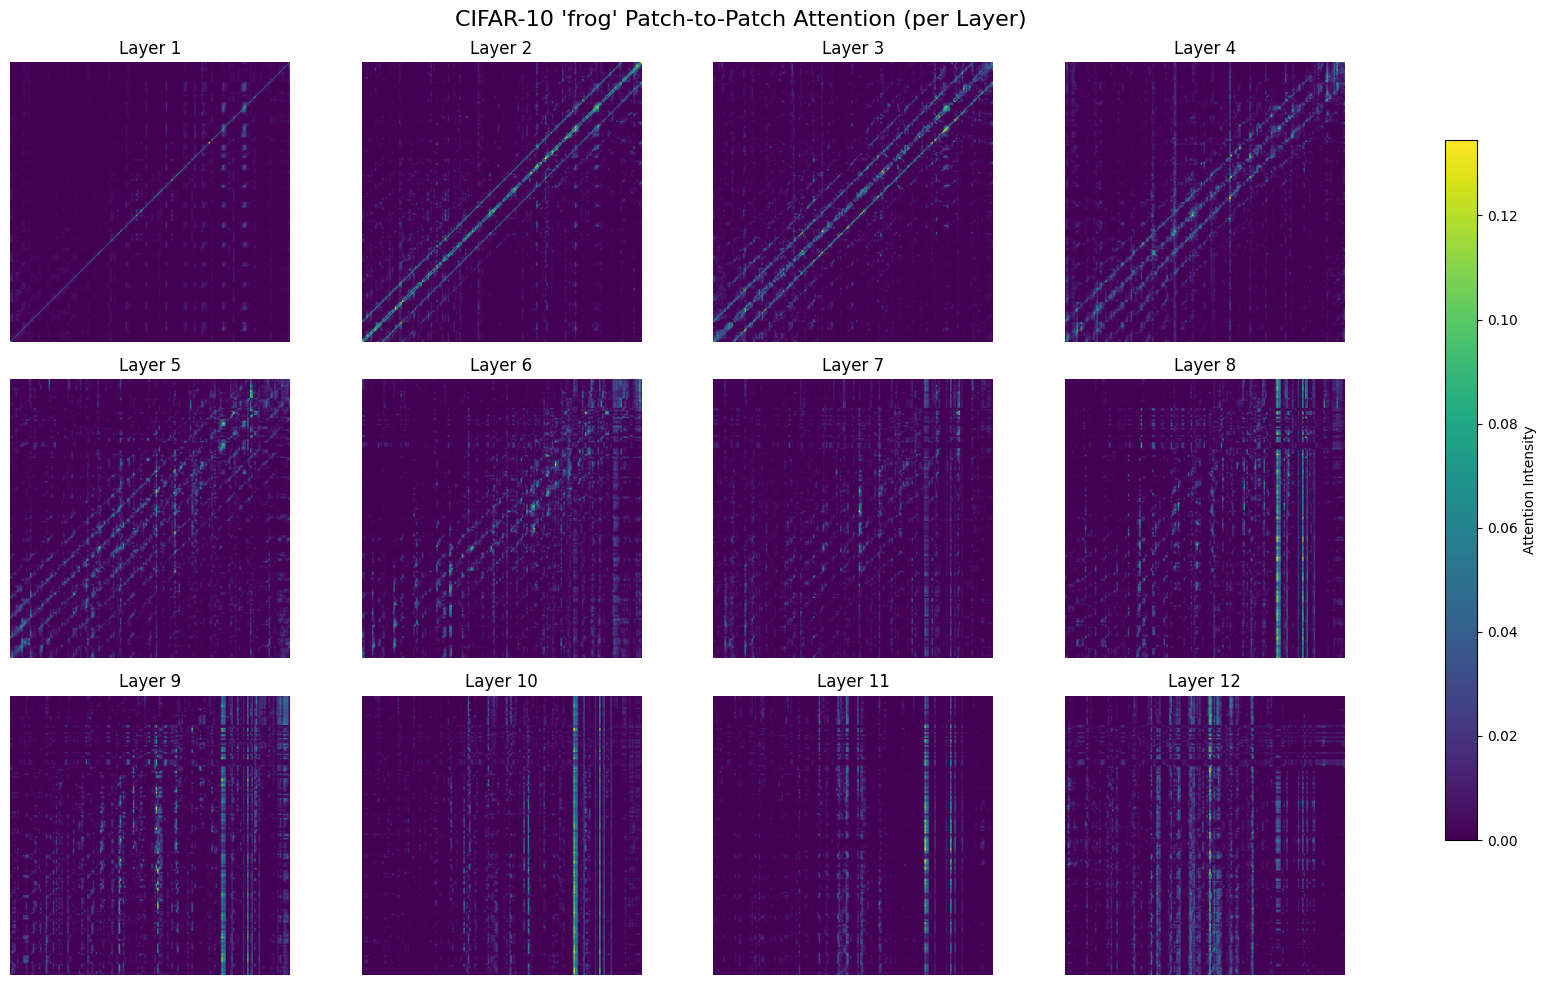

In [55]:
'''
모든 층에 대한 patch-to-patch 시각화 (testset 사용)
'''
import torch
import matplotlib.pyplot as plt
# 테스트 데이터 중 하나 선택
testset_idx = 5  # 보고 싶은 인덱스 (0~9999)
image, label = testset[testset_idx]

print(f"Selected CIFAR-10 Test Image | Class: {CLS2IDX[label]} (Label ID: {label})")

model_weight_save_path = 'record\\evaluations\\vit_LRP_AdaptiveEntmax_cifar10_epoch5\\20251120_013303\\model_weights.pth'

# 모델 로드
model.load_state_dict(torch.load(model_weight_save_path))
model.enable_hooks = True
model.eval()

# 입력 변환 및 forward
input_tensor = image.unsqueeze(0).cuda()
_ = model(input_tensor)

# Transformer 각 층의 Attention 추출
num_layers = len(model.blocks)
attn_maps = []
for i in range(num_layers):
    attn = model.blocks[i].attn.get_attn()  # [1, num_heads, 197, 197]
    mean_attn = attn.mean(dim=1)[0, 1:, 1:]  # 평균 헤드 attention [196, 196]
    attn_maps.append(mean_attn.detach().cpu().numpy())

# 시각화
row, col = 0, 4
if num_layers % col != 0:
    row = num_layers // col + 1
else:
    row = num_layers // col


fig, axes = plt.subplots(row, col, figsize=(16, 10))
fig.suptitle(f"CIFAR-10 '{CLS2IDX[label]}' Patch-to-Patch Attention (per Layer)", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < num_layers:
        im = ax.imshow(attn_maps[i], origin='lower')
        ax.set_title(f"Layer {i+1}")
        ax.axis('off')
    else:
        ax.axis('off')

# Colorbar 추가 (전체 figure에 대해 하나의 colorbar)
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Attention Intensity')

plt.tight_layout(rect=[0, 0, 0.92, 1])
plt.show()


Selected CIFAR-10 Test Image | Class: frog (Label ID: 6)


C:\Users\ucim\AppData\Local\Temp\ipykernel_18416\3047428287.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


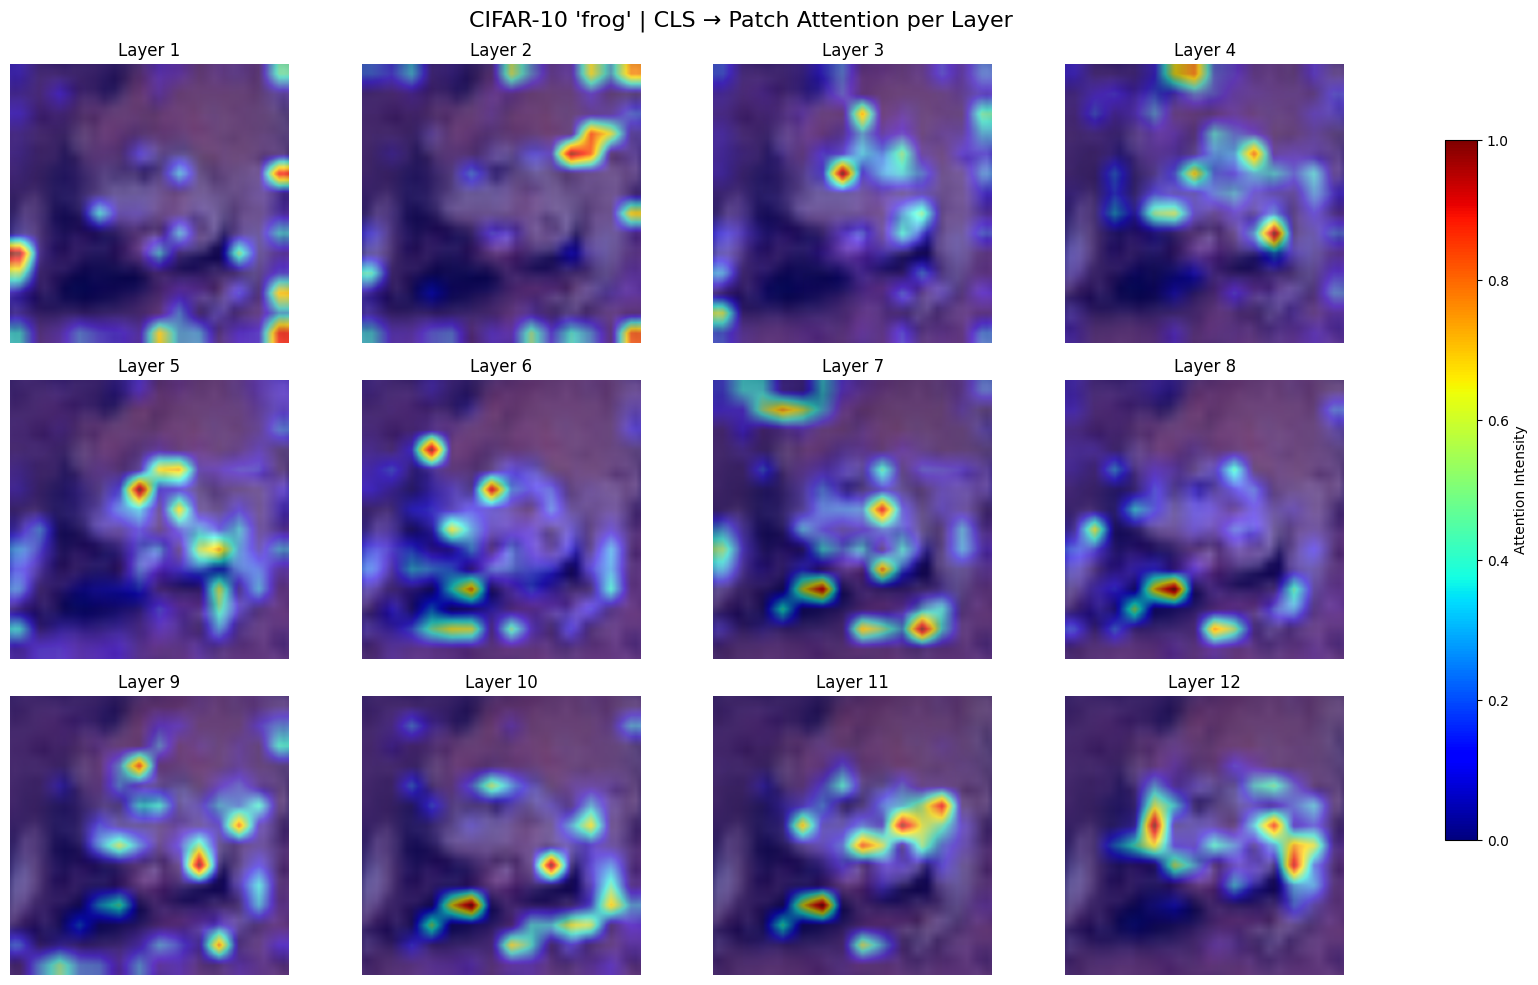

In [56]:
'''
모든 층에 대한 CLS → Patch Attention 시각화 (Tiny-ImageNet testset 사용)
'''
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision import datasets, transforms
from matplotlib.colors import Normalize

# 1. 테스트 이미지 하나 선택
idx = 5  # 다른 이미지를 보고 싶으면 인덱스 변경
image, label = testset[idx]

print(f"Selected CIFAR-10 Test Image | Class: {CLS2IDX[label]} (Label ID: {label})")

# 정규화 해제 (시각화용)
inv_normalize = transforms.Normalize(
    mean=[-1.0, -1.0, -1.0],
    std=[2.0, 2.0, 2.0]
)
img_for_vis = inv_normalize(image).permute(1, 2, 0).clamp(0, 1).numpy()  # [H, W, 3]

# 모델 로드
model.load_state_dict(torch.load(model_weight_save_path))
model.enable_hooks = True
model.eval()

# 입력 변환 및 forward
input_tensor = image.unsqueeze(0).cuda()  # [1, 3, 224, 224]
_ = model(input_tensor)

# CLS → Patch Attention 추출
num_layers = len(model.blocks)
attn_maps = []
raw_attn_maps = []  # 원본 attention 값 저장

methods = {
    "nearest": cv2.INTER_NEAREST,
    "bilinear": cv2.INTER_LINEAR,
    "bicubic": cv2.INTER_CUBIC,
}

for i in range(num_layers):
    attn = model.blocks[i].attn.get_attn()  # [1, num_heads, 197, 197]
    cls_attn = attn.mean(dim=1)[0, 0, 1:].reshape(14, 14)  # CLS → patch 평균 attention

    # Normalize (0~1)
    cls_attn = (cls_attn - cls_attn.min()) / (cls_attn.max() - cls_attn.min())
    cls_attn = cls_attn.detach().cpu().numpy()

    # 업샘플링 (224x224)
    cls_attn_resized = cv2.resize(cls_attn, (224, 224), interpolation=methods["bilinear"])
    cls_attn_resized = (cls_attn_resized - cls_attn_resized.min()) / (cls_attn_resized.max() - cls_attn_resized.min())

    # Heatmap 생성 및 원본 이미지 Overlay
    cls_attn_resized = 1 - cls_attn_resized  # 색 반전
    heatmap = cv2.applyColorMap(np.uint8(255 * cls_attn_resized), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + np.float32(img_for_vis)
    overlay = overlay / overlay.max()  # Normalize (0~1)

    attn_maps.append(overlay)
    raw_attn_maps.append(cls_attn_resized)

# 시각화
col = 4
row = num_layers // col + (1 if num_layers % col != 0 else 0)
fig, axes = plt.subplots(row, col, figsize=(16, 10))
fig.suptitle(f"CIFAR-10 '{CLS2IDX[label]}' | CLS → Patch Attention per Layer", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < num_layers:
        ax.imshow(attn_maps[i])
        ax.set_title(f"Layer {i+1}")
        ax.axis('off')
    else:
        ax.axis('off')

# Colorbar 추가 (전체 figure에 대해 하나의 colorbar)
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
norm = Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, label='Attention Intensity')

plt.tight_layout(rect=[0, 0, 0.92, 1])
plt.show()


Selected CIFAR-10 image → Class: frog (Label ID: 6)
Predicted class: frog (ID=6)


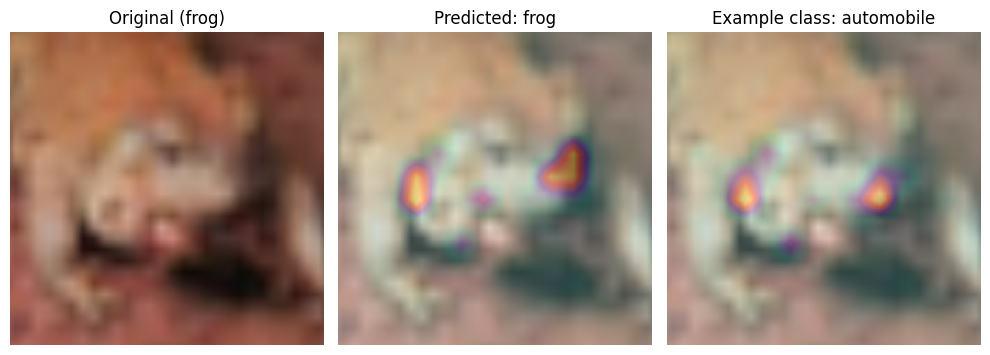

In [57]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

from modules.layers_ours import Linear

from baselines.ViT.ViT_LRP_default import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

# 1. 예시 이미지 하나 선택
idx = 5  # 다른 이미지를 보고 싶다면 인덱스 바꿔보세요
image, label = testset[idx]

print(f"Selected CIFAR-10 image → Class: {CLS2IDX[label]} (Label ID: {label})")

# 시각화를 위해 정규화 해제 (0~1로 복원)
inv_normalize = transforms.Normalize(
    mean=[-1.0, -1.0, -1.0],
    std=[2.0, 2.0, 2.0]
)
img_for_vis = inv_normalize(image).permute(1, 2, 0).clamp(0, 1).numpy()

# 모델 로드
model.load_state_dict(torch.load(model_weight_save_path))
model.enable_hooks = True
input_tensor.requires_grad = True
model.eval()

# LRP generator
attribution_generator = LRP(model)

# forward 및 예측 확인
input_tensor = image.unsqueeze(0).cuda()
output = model(input_tensor)
pred_class = torch.argmax(output, dim=1).item()

print(f"Predicted class: {CLS2IDX[label]} (ID={pred_class})")

# 시각화 (LRP heatmap)
def show_cam_on_image(img, mask):
    import cv2, numpy as np

    # (1) mask shape: [196] or [14×14]
    if mask.ndim == 1:
        mask = mask.reshape(14, 14)
    elif mask.shape[0] == 196:
        mask = mask.reshape(14, 14)

    # (2) resize heatmap to match image size (224×224)
    mask = cv2.resize(mask, (224, 224))

    # (3) normalize to 0~1
    mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)

    # (4) apply color map
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = 1 - heatmap # 색 반전

    # (5) overlay heatmap on image
    cam = 0.2*heatmap + 0.8*np.float32(img)
    cam = cam / np.max(cam)
    return cam

# 예측된 클래스에 대한 heatmap
vis_pred = attribution_generator.generate_LRP(input_tensor, method="transformer_attribution", index=pred_class)

# 다른 클래스 하나(예: class_index=0)와 비교 시각화도 가능
vis_other = attribution_generator.generate_LRP(input_tensor, method="transformer_attribution", index=0)

# 결과 표시
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].imshow(img_for_vis)
axs[0].set_title(f"Original ({CLS2IDX[label]})")
axs[0].axis('off')

axs[1].imshow(show_cam_on_image(img_for_vis, vis_pred[0].detach().cpu().numpy()))
axs[1].set_title(f"Predicted: {CLS2IDX[pred_class]}")
axs[1].axis('off')

axs[2].imshow(show_cam_on_image(img_for_vis, vis_other[0].detach().cpu().numpy()))
axs[2].set_title(f"Example class: {CLS2IDX[1]}")
axs[2].axis('off')

plt.tight_layout()
plt.show()
